## Whole-brain analysis of recruitment and integration change

In [283]:
library(tidyverse)
library(nlme)
library(lattice)
library(RcppCNPy)
library(reticulate)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1,
          )

### Loading data

In [303]:
setwd("~/Dropbox/Projects/LearningBrain/")

# Load parcellation
parcellation <- 'schaefer'
option <- 'normalized' # 'raw'

filename <- paste('whole-brain', parcellation, option, 'mean_allegiance_tidy.csv', sep = '_')

networks_allegiance <- read.csv(paste0('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/', filename))
dualnback_exclude <- c('sub-13', 'sub-21', 'sub-23', 'sub-50') # higly motion subjects in one of four sessions
unique_networks <- unique(networks_allegiance$Network)
networks_allegiance$Session <- factor(networks_allegiance$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))
networks_allegiance$Group <- factor(networks_allegiance$Group, levels = c('Experimental', 'Control'))

networks_allegiance <- networks_allegiance %>% 
                       filter(!(Subject %in% dualnback_exclude))
head(networks_allegiance)

Subject,Session,Group,Network,CON,DA,DM,LIM,SAL,SOM,VIS
sub-01,Naive,Control,CON,1.0410895,0.8708919,1.1054350,0.9735413,0.9580644,0.9265417,1.0024763
sub-01,Naive,Control,DA,0.8708919,1.2568347,0.8487052,1.0694059,1.0092778,1.0882465,0.8637120
sub-01,Naive,Control,DM,1.1054350,0.8487052,1.2188549,0.9587964,0.8924056,0.8928262,1.0011081
sub-01,Naive,Control,LIM,0.9735413,1.0694059,0.9587964,1.0817365,0.9883499,1.0295118,0.9475368
sub-01,Naive,Control,SAL,0.9580644,1.0092778,0.8924056,0.9883499,1.0780527,1.0443521,1.0120761
sub-01,Naive,Control,SOM,0.9265417,1.0882465,0.8928262,1.0295118,1.0443521,1.0805937,1.0164299


### MLM modeling for all networks

In [304]:
mlm_stats <- data.frame()
mlm_params <- data.frame()

for (i in 1:length(unique_networks)){
    for (j in i:length(unique_networks)){
        
        network1 = as.character(unique_networks[i])
        network2 = as.character(unique_networks[j])
    
        net = networks_allegiance %>% filter(Network == network1)
        variable <- net[[network2]]


        baseline <- lme(variable ~ 1, random = ~ 1 |Subject/Session, data = net, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
        session <- update(baseline, .~. + Session)
        group <- update(session, .~. + Group)
        session_group <- update(group, .~. + Session:Group)

        #print(paste(network1, network2))
        stats <- anova(baseline, session, group, session_group)
        params_session <- summary(session)
        params_interaction <- summary(session_group)
        
        vector_stats <- c(i, j, 
                          stats['L.Ratio'][2,], stats['L.Ratio'][3,], stats['L.Ratio'][4,], 
                          stats['p-value'][2,], stats['p-value'][3,], stats['p-value'][4,])
        
        vector_params <- c(i, j,
                           params_session$tTable[2,1], params_session$tTable[3,1], params_session$tTable[4,1], # betas
                           params_session$tTable[2,4], params_session$tTable[3,4], params_session$tTable[4,4], # ttests
                           params_session$tTable[2,5], params_session$tTable[3,5], params_session$tTable[4,5], # pvals
                           params_interaction$tTable[6,1], params_interaction$tTable[7,1], params_interaction$tTable[8,1], # betas
                           params_interaction$tTable[6,4], params_interaction$tTable[7,4], params_interaction$tTable[8,4], # ttests
                           params_interaction$tTable[6,5], params_interaction$tTable[7,5], params_interaction$tTable[8,5]) # pvals
                                    
        mlm_stats <- rbind(mlm_stats, vector_stats)
        mlm_params <- rbind(mlm_params, vector_params)

     }
}

colnames(mlm_stats) <- c('i', 'j', 
                         'chi_session', 'chi_group', 'chi_interaction', 
                         'pval_session', 'pval_group', 'pval_interaction')
colnames(mlm_params) <- c('i', 'j', 
                          'beta12_session', 'beta13_session', 'beta14_session', 
                          'ttest12_session', 'ttest13_session', 'ttest14_session',
                          'pval12_session', 'pval13_session', 'pval14_session',
                          'beta12_interaction', 'beta13_interaction', 'beta14_interaction', 
                          'ttest12_interaction', 'ttest13_interaction', 'ttest14_interaction',
                          'pval12_interaction', 'pval13_interaction', 'pval14_interaction')

write.csv(mlm_stats, paste('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/whole-brain', parcellation, option, 'mlm_stats.csv', sep = "_"))
write.csv(mlm_params, paste('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/whole-brain', parcellation, option, 'mlm_params.csv', sep = "_"))

In [164]:
for (i in 1:length(unique_networks)){
    for (j in 1:length(unique_networks)){
        
        network1 = as.character(unique_networks[i])
        network2 = as.character(unique_networks[j])
    
        net = networks_allegiance %>% filter(Network == network1)
        variable <- net[[network2]]


        baseline <- lme(variable ~ 1, random = ~ 1 |Subject/Session, data = net, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
        session <- update(baseline, .~. + Session)
        group <- update(session, .~. + Group)
        session_group <- update(group, .~. + Session:Group)

        #print(paste(network1, network2))
        results <- anova(baseline, session, group, session_group)
        
        # Session effects
        mlm_results[1,1,i,j] <-  results['L.Ratio'][2,]
        mlm_results[1,2,i,j] <-  results['p-value'][2,]
        
        # Interaction effects
        mlm_results[2,1,i,j] <-  results['L.Ratio'][4,]
        mlm_results[2,2,i,j] <-  results['p-value'][4,]

     }
}

### Correcting for multiple comparison (FDR)

In [173]:
for (i in 1:2){
    fdr_corr_mat = matrix(0,n_net,n_net)
    fdr_corr <- p.adjust(mlm_results[i,2,,][lower.tri(mlm_results[i,2,,], diag = TRUE)], method = "fdr")
    fdr_corr_mat[lower.tri(fdr_corr_mat, diag = TRUE)] <- fdr_corr
    
    # Making matrix symmetric
    fdr_corr_mat <- fdr_corr_mat + t(fdr_corr_mat)
    diag(fdr_corr_mat) <- diag(fdr_corr_mat)/2
    mlm_results[i,3,,] <- fdr_corr_mat
    
}

In [210]:
library(RcppCNPy)



### Plotting results

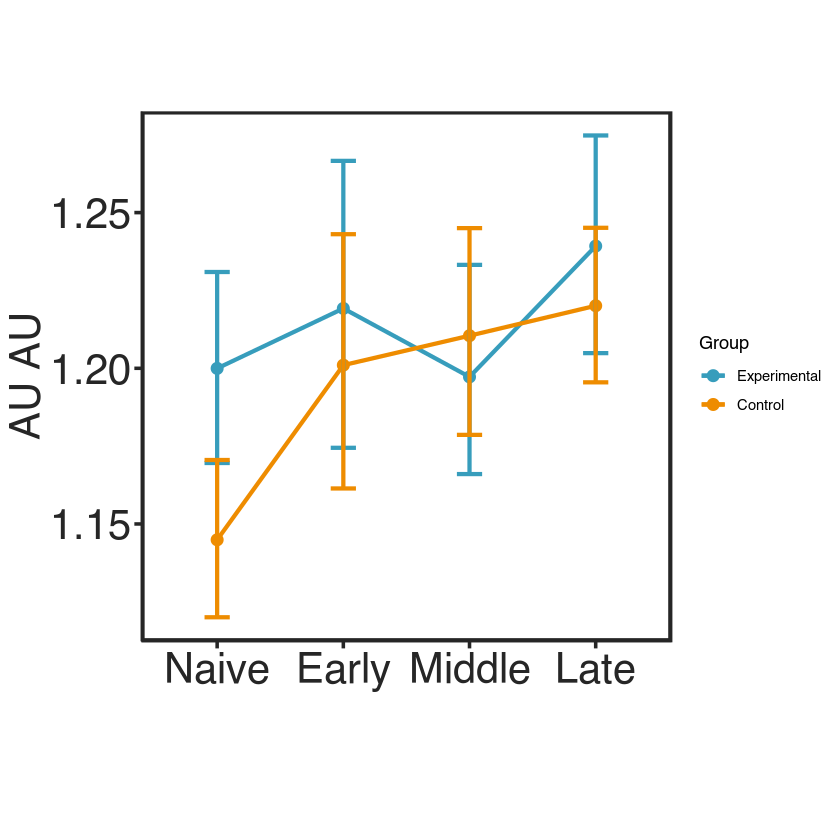

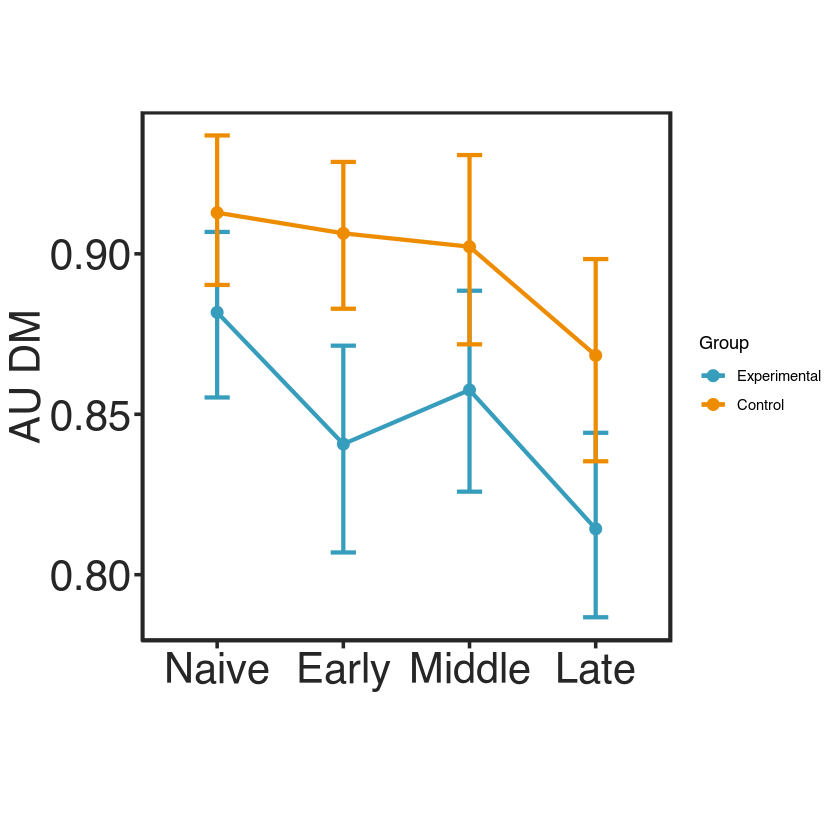

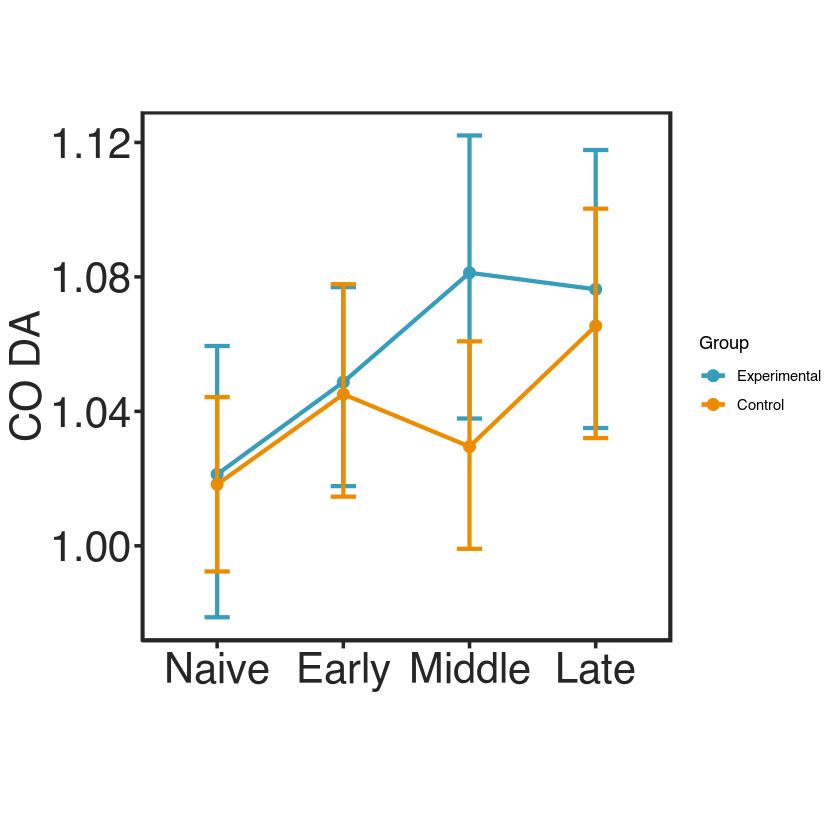

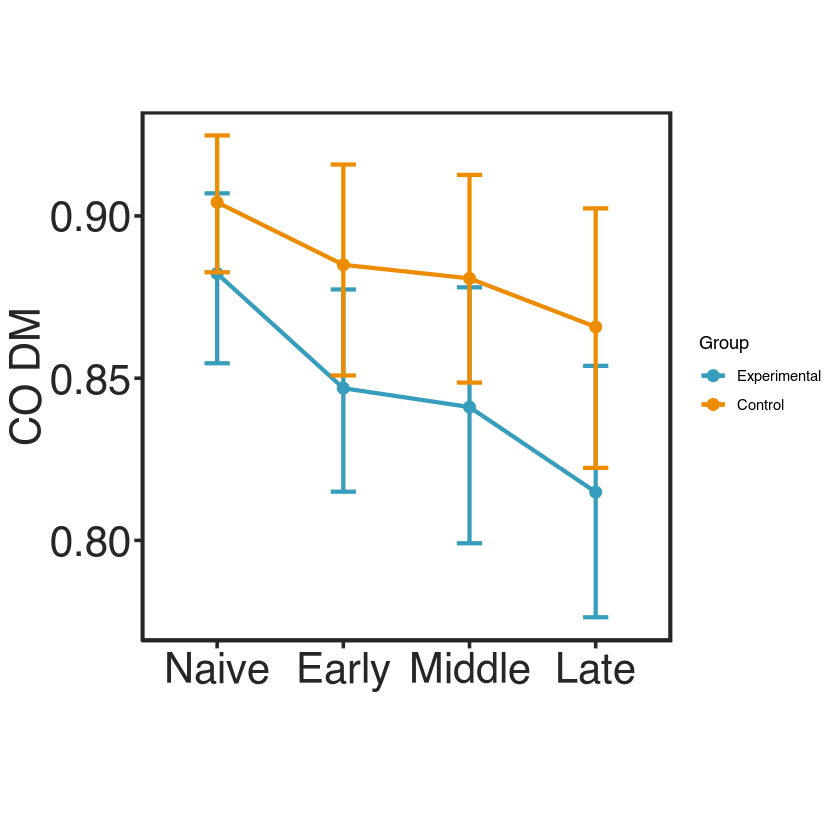

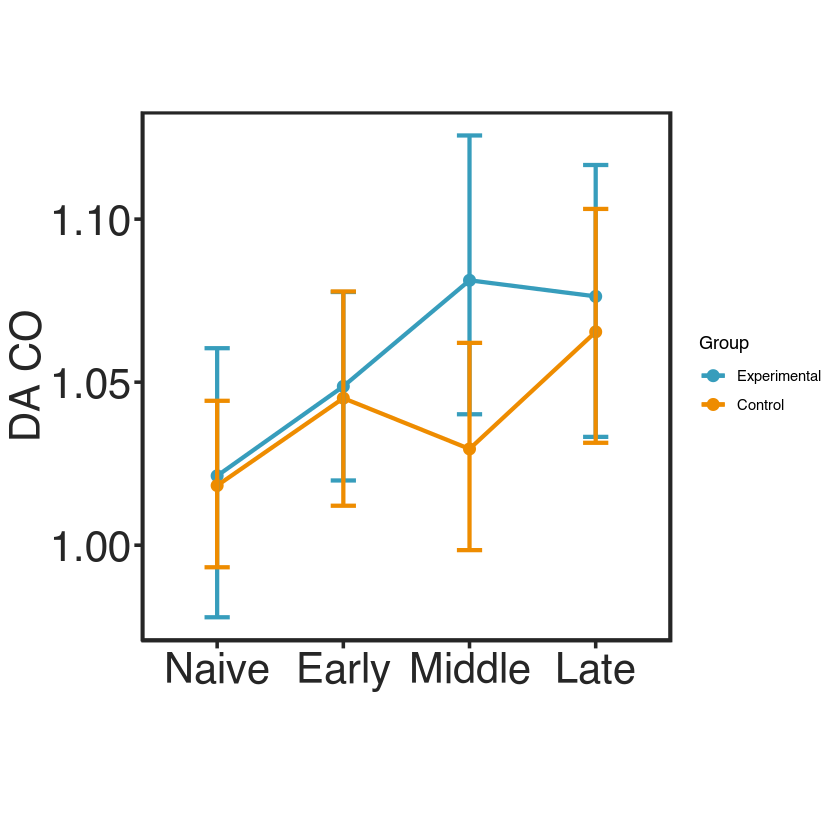

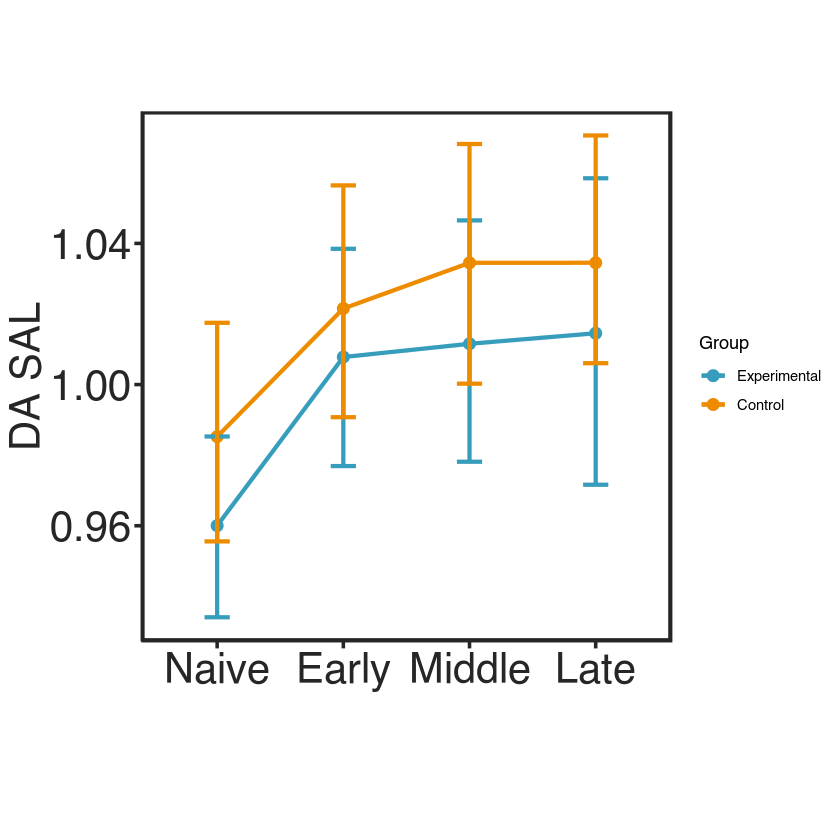

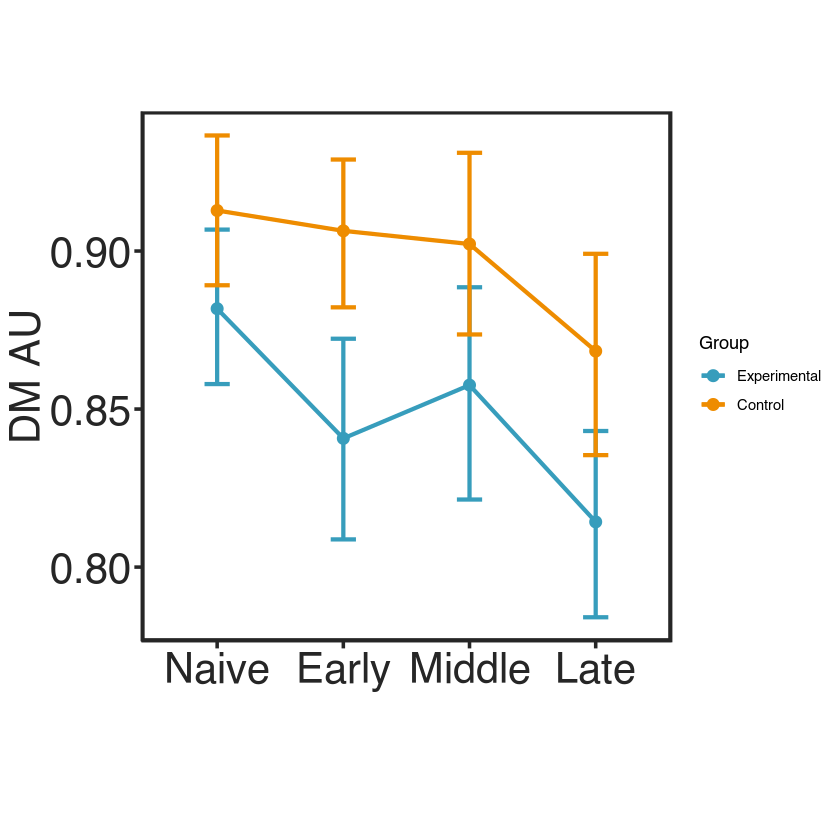

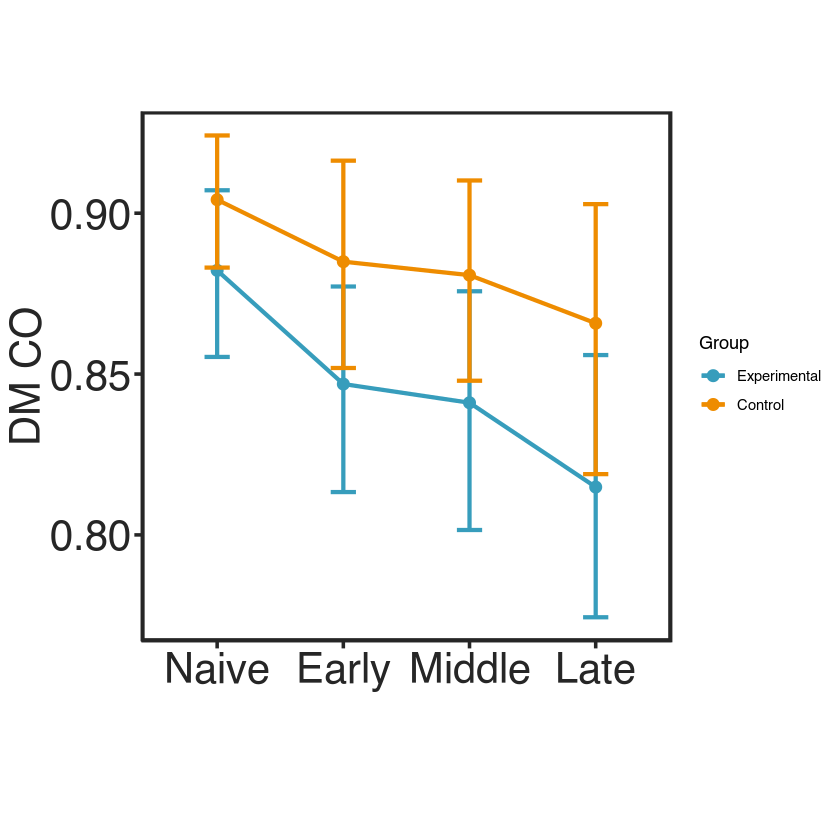

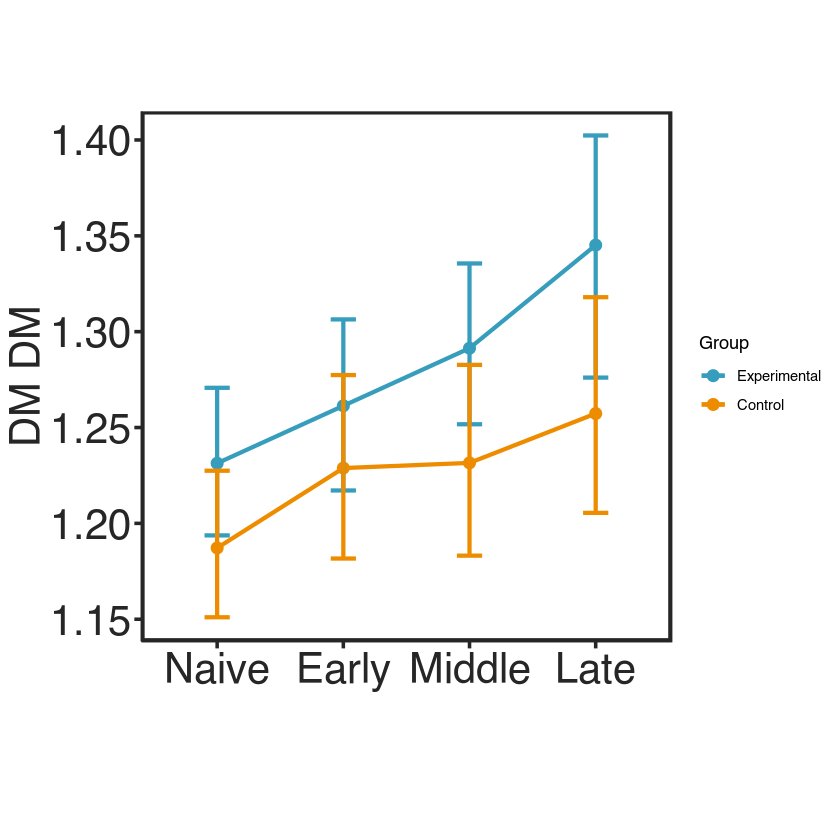

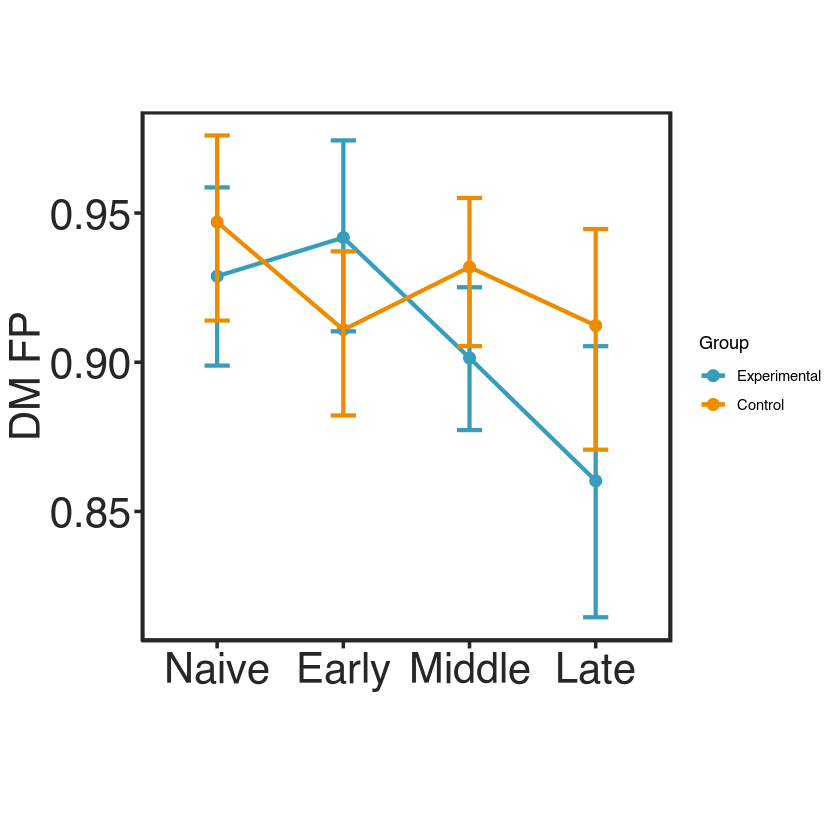

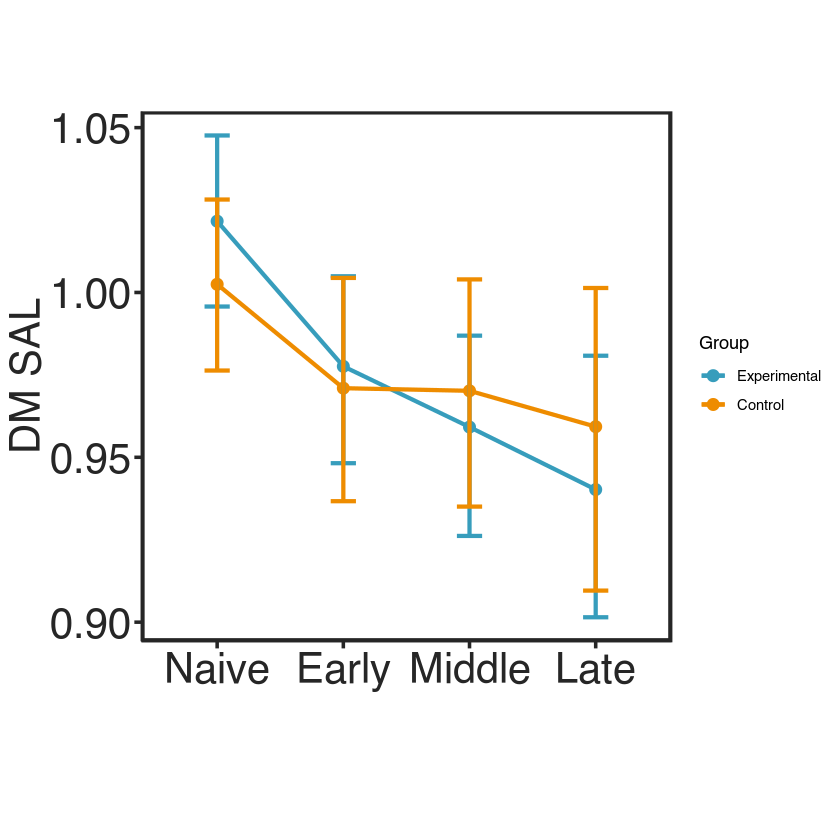

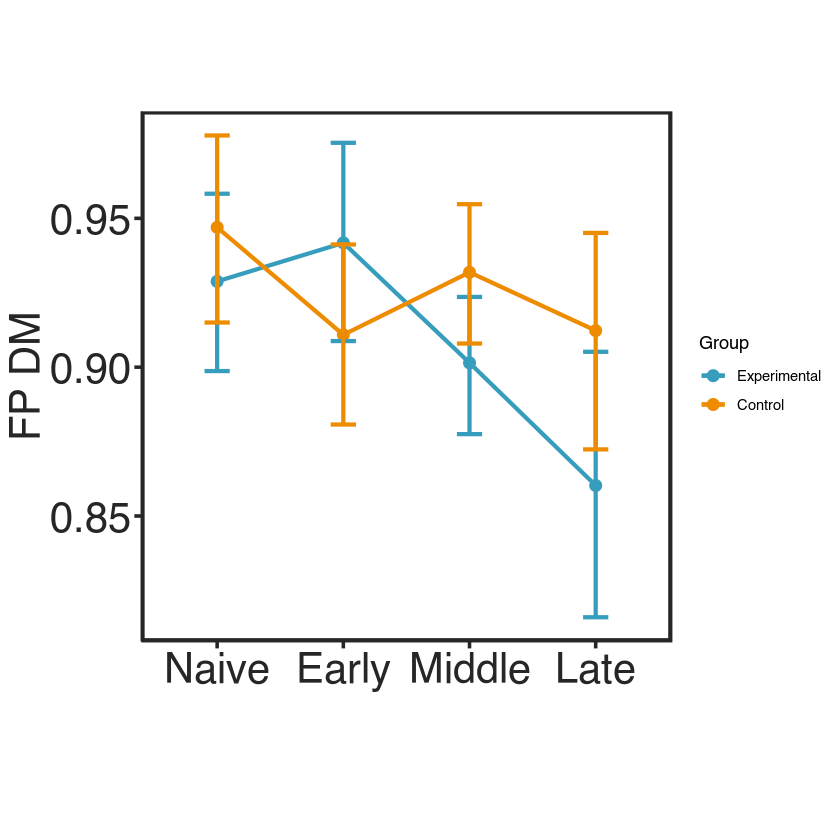

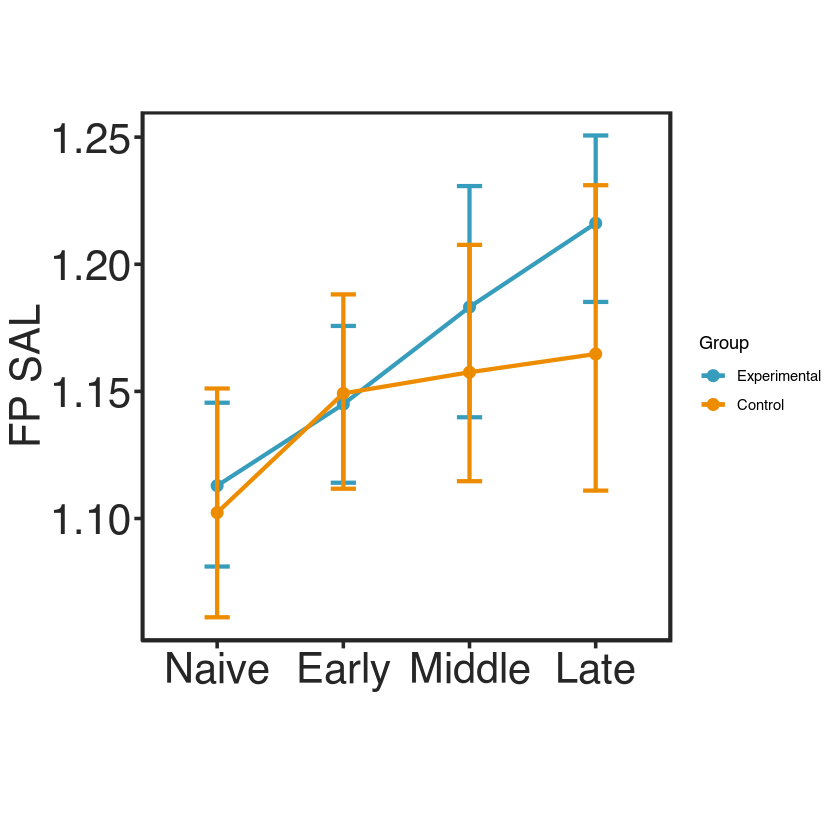

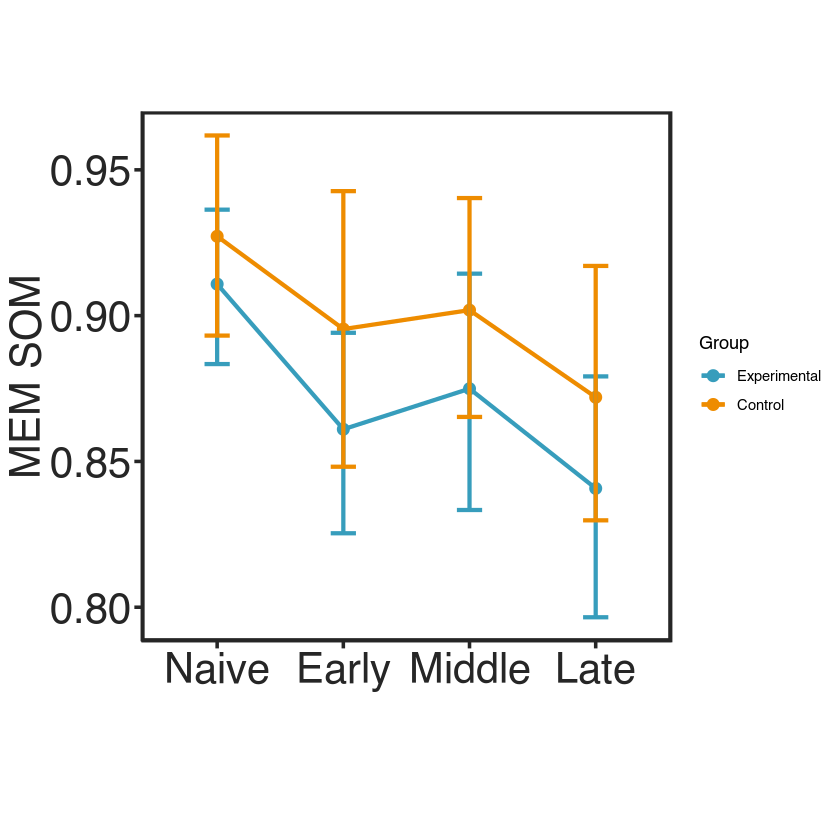

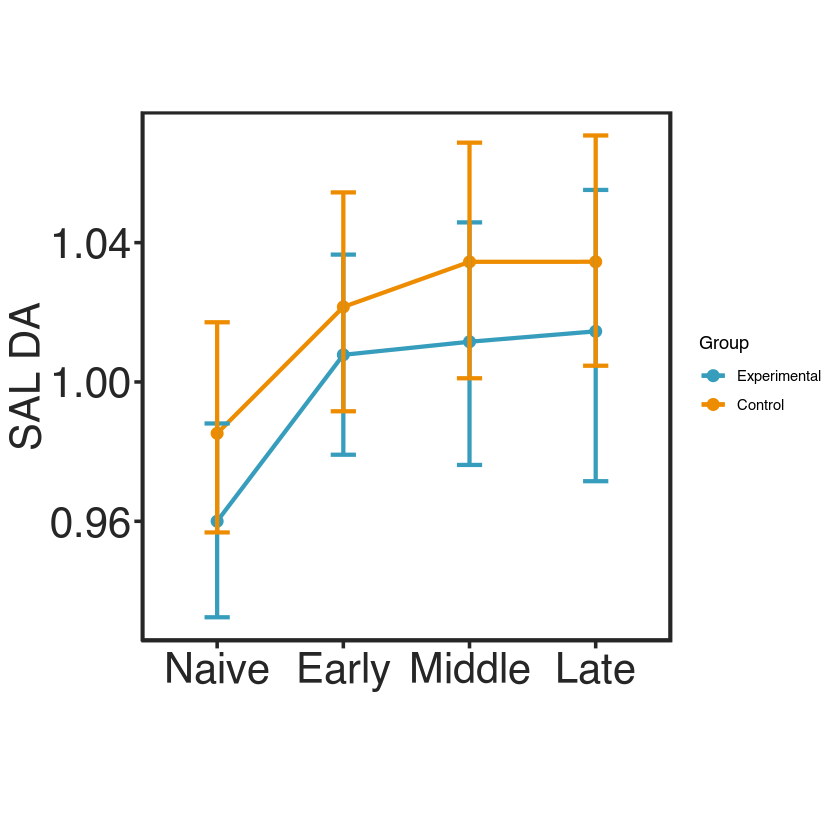

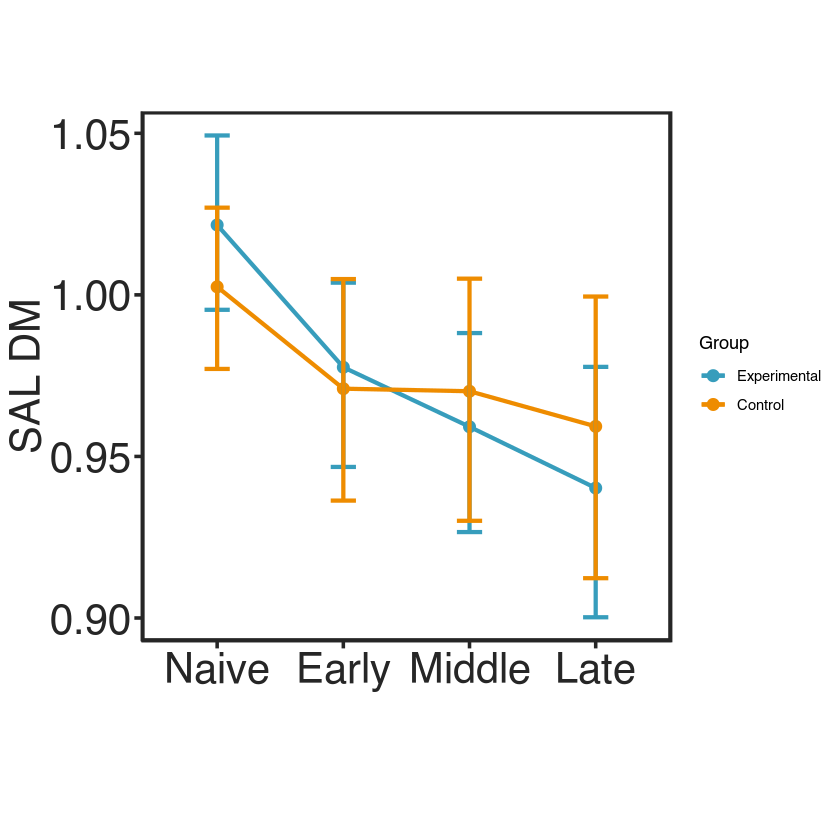

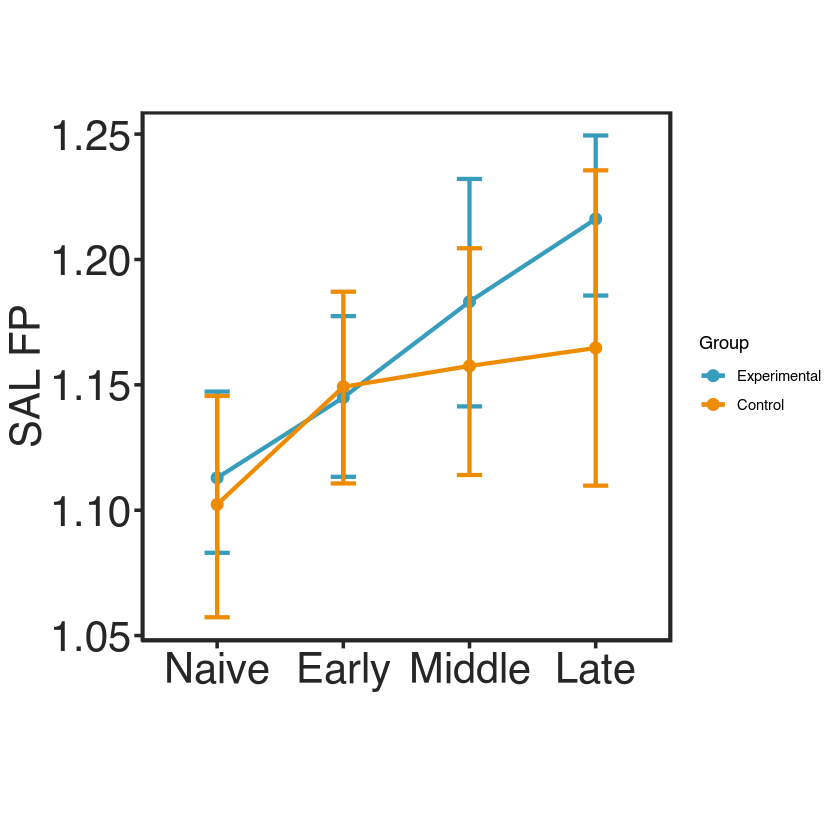

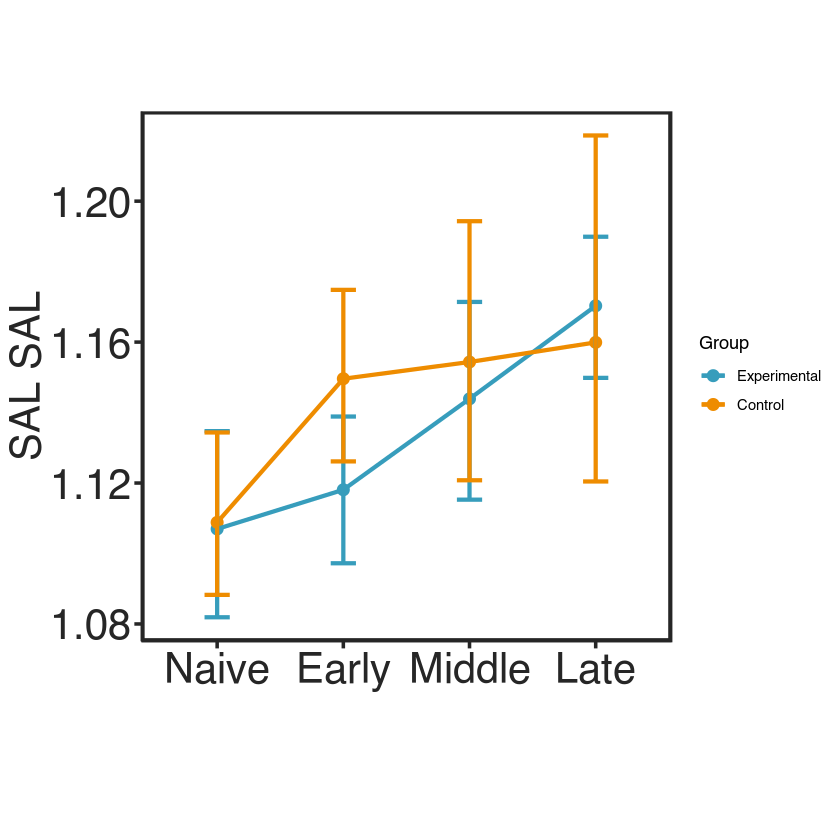

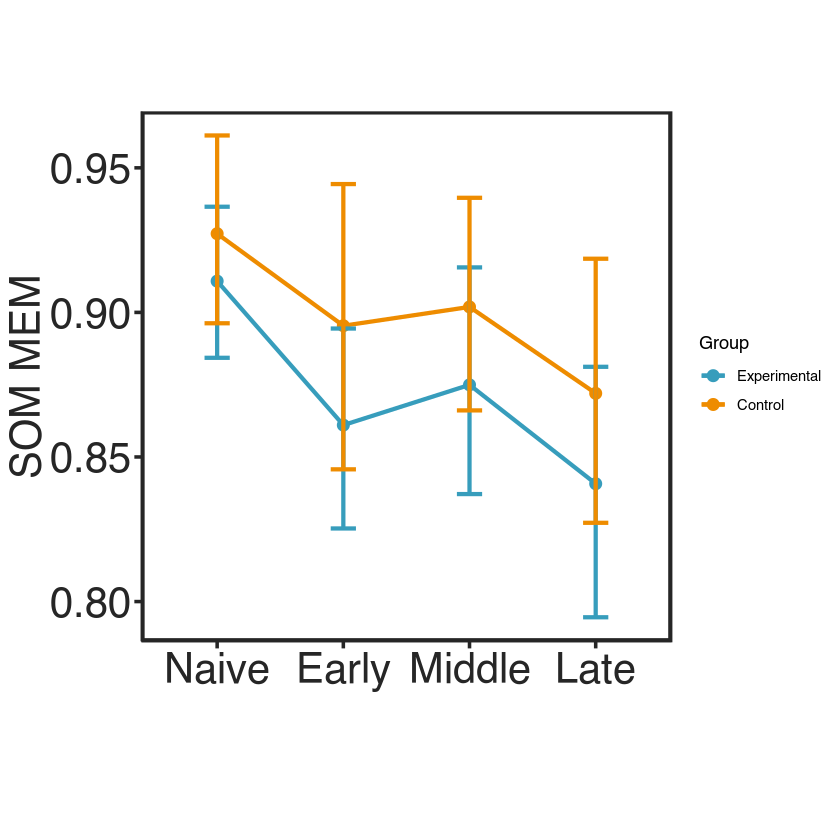

In [193]:
for (i in 1:length(unique_networks)){
    for (j in 1:length(unique_networks)){
        
        network1 = as.character(unique_networks[i])
        network2 = as.character(unique_networks[j])      
        
        if (mlm_results[1,3,i,j] < 0.05){
            
            net = networks_allegiance %>% filter(Network == network1)
            variable <- net[[network2]]
            
            p <- ggplot(net, aes(x = Session, y = variable, col = Group)) +
                stat_summary(fun.y = mean, geom = 'point', size = 3) +
                stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
                stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
                ylab(paste(network1, network2)) +
                scale_colour_manual(values=c('#379dbc','#ee8c00')) +
                theme_training +
                xlab(' ')
             print(p)
           
        }
        
    }
}
     

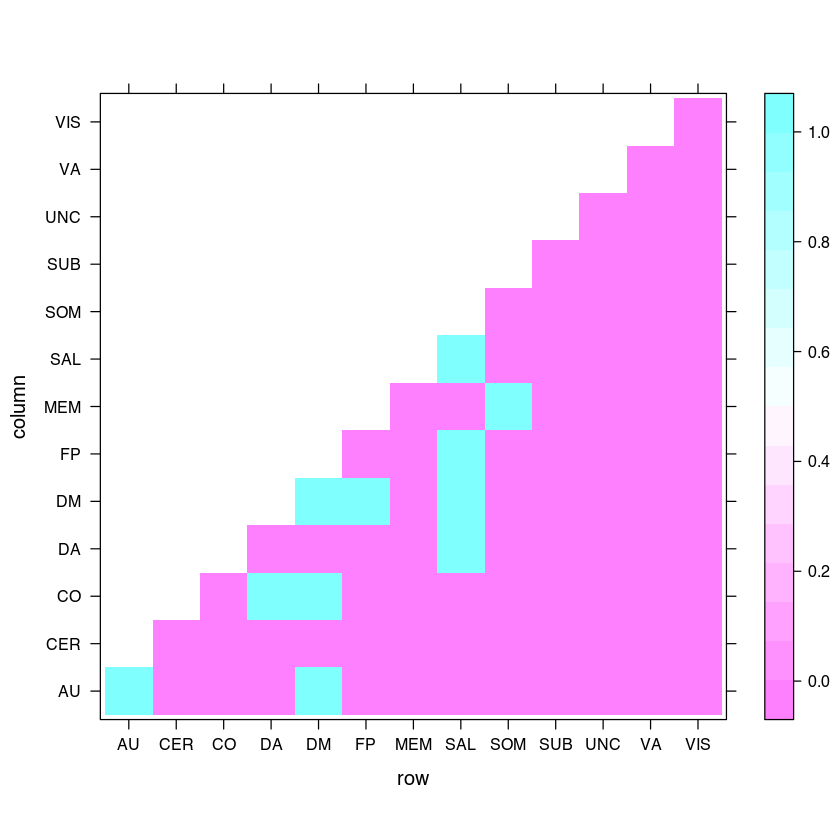

In [19]:
levelplot(fdr_corr_mat < 0.05)

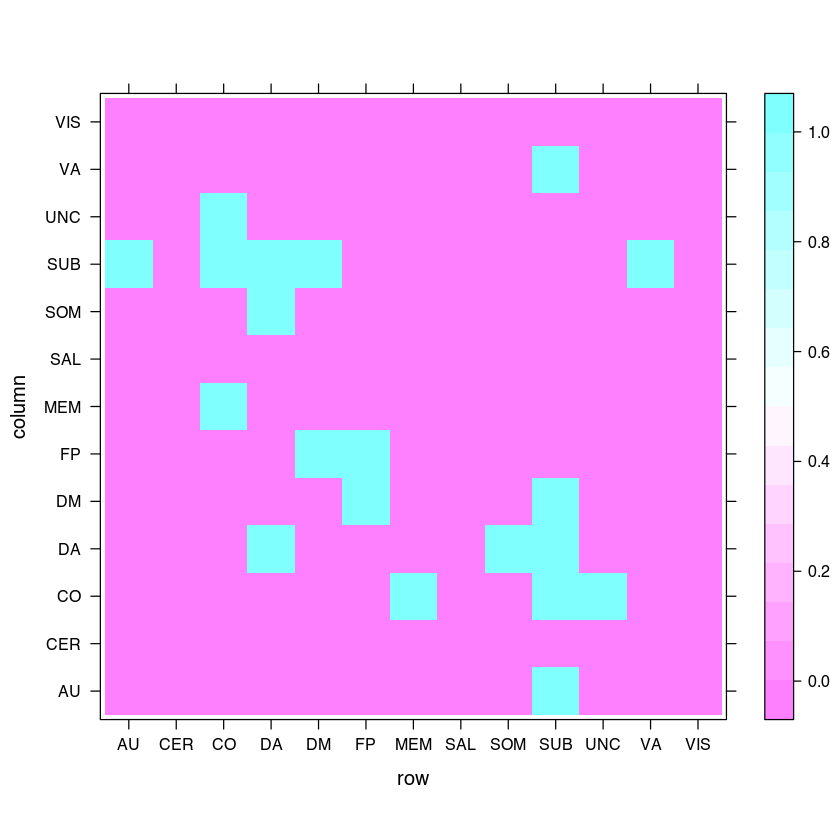

In [143]:
levelplot(interaction_effects < 0.05)

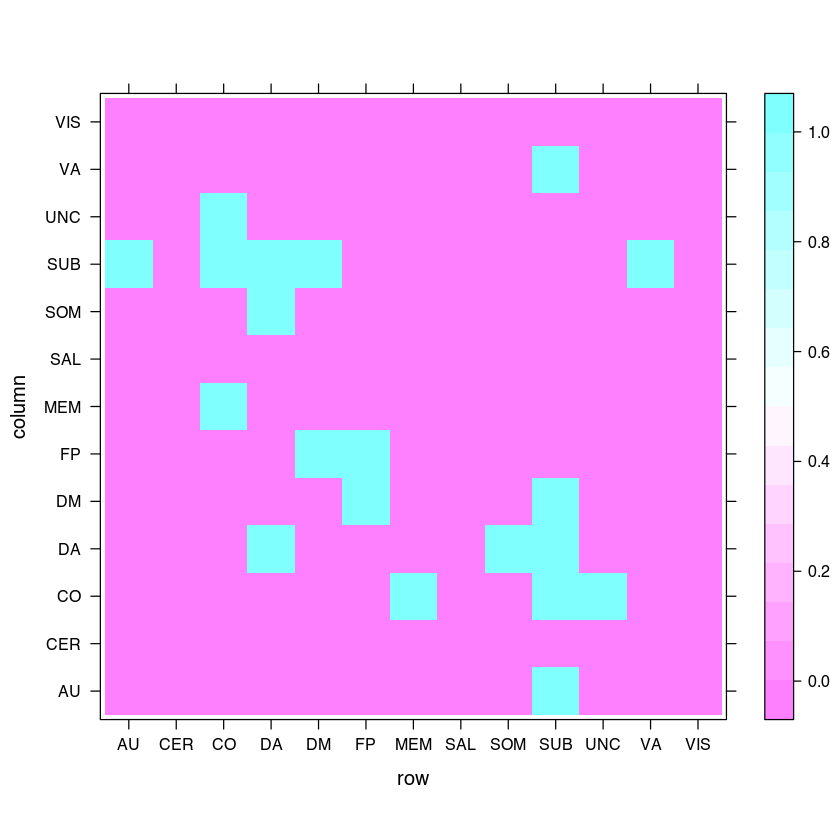

In [109]:
levelplot(interaction_effects < 0.05)